这个部分主要用于处理EMNIST数据来进行一定程度的数据增广

mapping file:
映射表

label file:
label指代的是每个图片所代表的字符

ubyte file:
balanced set: 里面包含了EMNIST测试集的图像数据
byclass set: 包含了按类划分的图像数据
bymerge set: 存储了合并字符的图像数据
digits set: 存储了数字的图像数据
letter set: 存储了单一字母的图像数据
Mnist set: 存储了 MNIST 训练机图像数据

因此为了满足需求，我目前只需要处理 Digits set 以及 letter set 将他们提取出来


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import requests
import re

In [7]:
# Load the image data
def load_emnist_images(file_path):
    with open(file_path, 'rb') as f:
        # 读取前16个字节并解包为4个无符号整数 （因为每个整数都有4个字节，一共4个所以要读前16位）
        magic, num_images, num_rows, num_cols = struct.unpack(">IIII", f.read(16))
        # 读取剩余的数据并转换为8位无符号整数 （内容是实际图像数据范围是 0-255， 一个像素点一个byte）
        images = np.fromfile(f, dtype = np.uint8).reshape(num_images, num_rows, num_cols)
        # 调整图像通道顺序，确保按照正常方式排列
        images = np.swapaxes(images, 1, 2)
    return images

In [6]:
# Load the label data
def load_emnist_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack("II", f.read(8))
        # 读取剩余的数据并转换为8位无符号整数（内容是实际标签数据，一个标签一个字节）
        labels = np.fromfile(f, dtype = np.uint8)
    return labels

In [13]:
# 定义digits数据集路径
digits_images_train_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-digits-train-images-idx3-ubyte"
digits_labels_train_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-digits-train-labels-idx1-ubyte"
digits_images_test_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-digits-test-images-idx3-ubyte"
digits_labels_test_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-digits-test-labels-idx1-ubyte"

In [14]:
# 加载图片和标签数据
digits_images_train = load_emnist_images(digits_images_train_path)
digits_labels_train = load_emnist_labels(digits_labels_train_path)
digits_images_test = load_emnist_images(digits_images_test_path)
digits_labels_test = load_emnist_labels(digits_labels_test_path)

Image shape: (28, 28)


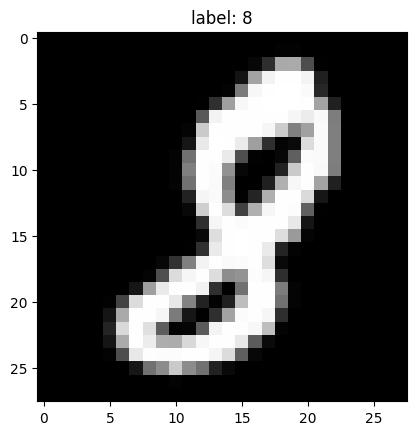

In [27]:
# 尝试打印第一张图片以及标签 (以train set测试)
first_digit_image = digits_images_train[0]
first_digit_label = digits_labels_train[0]

print(f"Image shape: {first_digit_image.shape}")

# 显示图片
plt.imshow(first_digit_image, cmap="gray")
plt.title(f"label: {first_digit_label}")
plt.show()

In [4]:
# 同样方法处理letters数据集

# 定义letters数据集路径
letters_images_train_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-letters-train-images-idx3-ubyte"
letters_labels_train_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-letters-train-labels-idx1-ubyte"
letters_images_test_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-letters-test-images-idx3-ubyte"
letters_labels_test_path = "/root/autodl-tmp/APS360_Project/Datasets/EMNIST_unzip/emnist-letters-test-labels-idx1-ubyte"

In [8]:
# 加载图片和标签
letters_images_train = load_emnist_images(letters_images_train_path)
letter_images_test = load_emnist_images(letters_images_test_path)
letters_labels_train = load_emnist_labels(letters_labels_train_path)
letters_labels_test = load_emnist_labels(letters_labels_test_path)

Image shape: (28, 28)


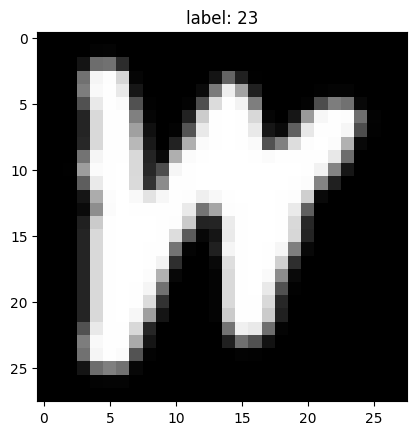

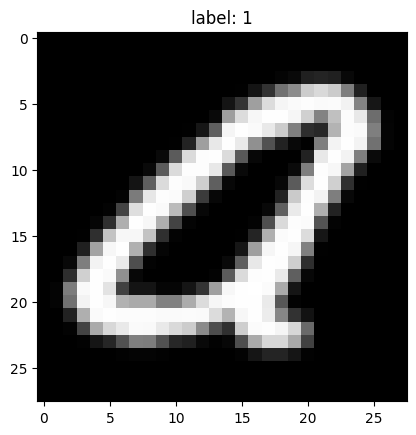

In [17]:
first_letter_image = letters_images_train[0]
first_letter_label = letters_labels_train[0]

print(f"Image shape: {first_letter_image.shape}")

# 显示图片
plt.imshow(first_letter_image, cmap="gray")
plt.title(f"label: {first_letter_label}")
plt.show()

# 打印label为1的图片
# 找到第一个label为1的图片
first_one_index = np.where(letters_labels_train == 1)[0][0]
first_one_image = letters_images_train[first_one_index]

# 显示图片
plt.imshow(first_one_image, cmap="gray")
plt.title(f"label: 1")
plt.show()

In [21]:
# 打印所有的字母label

print("Letter labels:")
print(np.unique(letters_labels_train))

Letter labels:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]


从labels可见对应的是
a -> 1
b -> 2
.
.
.
z -> 26

In [ ]:
# 定义bycalss path (upper-case)

In [10]:
# 尝试读取 https://www.gutenberg.org/cache/epub/64317/pg64317.txt 内容

# 下载网页文件
url = "https://www.gutenberg.org/cache/epub/64317/pg64317.txt"
response = requests.get(url)
text = response.text

# 初始化变量
word_count = 0
paragraphs = ''
current_paragraph = ''
current_word = ''

# 每90个单词组成一个段落
for char in text:
    if char.isalnum():
        current_word += char
    else:
        if current_word:
            word_count += 1
            current_paragraph += current_word
            current_word = ''
        if char == '\n':
            current_paragraph += '\n'
        elif char == '\r':
            continue  # 忽略 '\r' 符号，因为 '\n' 已经处理了换行
        elif re.match(r'[^\w\s]', char) or char == ' ':
            current_paragraph += char
    
    # 每90个单词形成一个段落
    if word_count == 90:
        paragraphs += current_paragraph
        current_paragraph = ''
        word_count = 0
        break

# 将最后剩余的部分（不超过90个词）添加到paragraph
if current_paragraph or current_word:
    current_paragraph += current_word
    paragraphs.append(current_paragraph)

print(paragraphs)

The Project Gutenberg eBook of The Great Gatsby
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before 
